### Setup

#### Imports

In [1]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.run_clingo import run_clingo
from PW_explorer.visualize import PWEVisualization
from PW_explorer.helper import pw_slicer, rel_slicer, rel_name_remapper
from PW_explorer.export import PWEExport
import pandas as pd
import os
from misc import *

In [2]:
import networkx as nx
from nxpd import draw
import nxpd
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [3]:
%load_ext PWE_NB_Extension

#### Helper Functions

In [4]:
def save_query_figs(query_analysis, folder='3hop_all_patterns_new'):
    fnames = {}
    for pw_id in range(1, len(query_analysis['pw_objs'])+1):
        pw_rel_dfs, pw_objs = pw_slicer(query_analysis['pw_rel_dfs'], query_analysis['pw_objs'], [pw_id])
        pw_obj = pw_objs[0]

        node_fig_g = get_pattern_graph3(pw_rel_dfs, pw_obj, silent=True, 
                                        q_head='binary-node-highlight', 
                                        chain_eq_node_labels=False)
        q_str = print_rewritten_query_string(pw_rel_dfs, html=False, display_q=False, include_ineqls=False)
        q_str = q_str.replace('thop', 'q')
        node_fig_g.graph['label'] = q_str
        node_fig_g.graph['labelloc'] = 't' # options 't', 'b'
        fname = '{}.{}'.format('{}/pw_{}'.format(folder, pw_id), 'png')
        draw(node_fig_g, filename=fname, show=False)
        fnames[pw_id] = fname
    return fnames

#### Supplementary ASP Encodings

In [5]:
%%clingo --donot-display_input --donot-run -lci query_analysis_suppl

% schema ruleOccTrue(ATOM, OCC)
ruleOccTrue(R, OC) :- ruleOcc(R, OC).
% schema ruleHTrue(HEAD)
ruleHTrue(H)  :- ruleH(H).
% schema newVar(VAR, DOMAIN)
newVar(VAR, TYPE) :- var(VAR, TYPE), not eqOrd(_,VAR,TYPE).
% schema eqOrdMinimal(VAR1, VAR2, DOMAIN)
eqOrdMinimal(A,B,TYPE) :- eqOrd(A,B,TYPE), newVar(A,TYPE).
% schema neqOrd(VAR1, VAR2, DOMAIN)
neqOrd(A,B,TYPE) :- newVar(A,TYPE), newVar(B,TYPE), A<B.

% New inferred edges
% schema e(NODE1, NODE2)
e(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC).
% schema e(OCC, NODE1, NODE2)
e(OCC,V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC).
    
%graphviz graph graph_type=directed rankdir=LR
%graphviz edge newArc(HEAD, _, TAIL) label=$2
%graphviz node ruleOccTrue(N) color=green

#show ruleOccTrue/2.
#show ruleHTrue/1.
#show var/2.
#show newVar/2.
#show ruleOcc/2.
#show ruleH/1.
#show eqOrd/3.
#show neqOrd/3.
#show eqOrdMinimal/3.
#show arc/4.
#show newArc/4.
#show hArc/3.
#show newHArc/3.
#show e/2.
#show e/3.

### Query Analysis

Say we want to statically analyze the well-studied 3hop/2 query:

__thop(X,Y) :- e(X,Z1), e(Z1,Z2), e(Z2,Y).__

To do this, we first encode the query as a incidence graph as shown below:

In [6]:
%%clingo --donot-display_input --donot-run -lci thop_query_desc

% Q: thop(X,Y) :- e(X,Z1), e(Z1,Z2), e(Z2,Y).

% Declare the variables appearing in the query:
% schema var(VAR, DOMAIN).
var("X", node).
var("Y", node).
var("Z1", node).
var("Z2", node).

% Declare the logical atoms in the body of the query:
% schema ruleOcc(ATOM, OCC).
ruleOcc("e", 1..3).

% Declare the logical atom in the head of the query:
% schema ruleH(HEAD).
ruleH("thop").

% Declare the edges of the incidence graph:
% schema arc(VAR, POS, ATOM, OCC).
arc("X",  1, "e", 1). % This means X is in the 1st position in the 1st "e" rule-atom
arc("Z1", 2, "e", 1). % ...
arc("Z1", 1, "e", 2). % ...
arc("Z2", 2, "e", 2). % This means Z2 is in the 2nd position in the 2nd "e" rule-atom
arc("Z2", 1, "e", 3). % and so on....
arc("Y",  2, "e", 3).

% Declare the edges from the "query-head" node
% Use the rules below to change the rule head.
% schema hArc(VAR, POS, HEAD).
hArc("X", 1, "thop") :- ruleH("thop").
hArc("Y", 2, "thop") :- ruleH("thop").

Next we encode the query analysis code that uses a query description such as the one above.

Within this analysis, we create Bell-Number(n) (i.e. B<sub>n</sub>) many partitions where n is the number of distinct variable in the query.

Then we recreate a new incidence graph where the we substitute each disjoint group in the partition with a representative variable (for simplicity, we use the lexicographically smallest variable).

In [7]:
%%clingo --donot-display_input -lci query_analysis_enc --donot-run

% Create variable partitions
% schema eq(VAR1, VAR2, DOMAIN)
eq(A,B,TYPE) ; not eq(A,B,TYPE) :- var(A, TYPE), var(B, TYPE), A!=B.
eq(A,B,TYPE) :- eq(B,A,TYPE).
eq(A,B,TYPE) :- eq(A,C,TYPE), eq(C,B,TYPE), A!=B, B!=C, A!=C.

% Order the individual partitions
% schema eqOrd(VAR1, VAR2, DOMAIN)
eqOrd(A,B,TYPE) :- eq(A,B,TYPE), A<B.

% Find the new arcs, getting rid of the redundant variables as per the orderings
% schema newArc(VAR, POS, ATOM, OCC)
newArc(VAR, POS, ATOM, OCC) :- arc(VAR_ORIG, POS, ATOM, OCC), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newArc(VAR, POS, ATOM, OCC) :- arc(VAR, POS, ATOM, OCC), not eqOrd(_,VAR,_).

% schema newHArc(VAR, POS, HEAD)
newHArc(VAR, POS, H) :- hArc(VAR_ORIG,POS,H), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newHArc(VAR, POS, H) :- hArc(VAR, POS, H), not eqOrd(_,VAR,_).

With these two encodings, we can create the specialized queries that make up the original query.

For clarity, let's project out the resultant e/2 and thop/2 relation that make up the query:

In [8]:
%%clingo --donot-display_input -l query_analysis_enc thop_query_desc

e(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC).
thop(V1,V2) :- newHArc(V1,1,"thop"), newHArc(V2,2,"thop").
#show e/2.
#show thop/2.

Output:


'Answer: 1\nthop("X","Y") e("X","Z1") e("Z1","Z2") e("Z2","Y")\nAnswer: 2\nthop("X","Y") e("Z1","Y") e("X","Z1") e("Z1","Z1")\nAnswer: 3\nthop("X","Y") e("X","Y") e("Y","Z2") e("Z2","Y")\nAnswer: 4\nthop("X","Y") e("Y","Y") e("Z1","Y") e("X","Z1")\nAnswer: 5\nthop("X","Y") e("X","Y") e("Y","Y")\nAnswer: 6\nthop("X","Y") e("X","Y") e("Z1","X") e("X","Z1")\nAnswer: 7\nthop("X","Y") e("X","Y") e("Y","X")\nAnswer: 8\nthop("X","Y") e("X","X") e("X","Z2") e("Z2","Y")\nAnswer: 9\nthop("X","Y") e("X","X") e("X","Y") e("Y","Y")\nAnswer: 10\nthop("X","Y") e("X","X") e("X","Y")\nAnswer: 11\nthop("X","X") e("X","Z1") e("Z2","X") e("Z1","Z2")\nAnswer: 12\nthop("X","X") e("Z1","X") e("X","Z1") e("Z1","Z1")\nAnswer: 13\nthop("X","X") e("X","X") e("Z1","X") e("X","Z1")\nAnswer: 14\nthop("X","X") e("X","X") e("Z2","X") e("X","Z2")\nAnswer: 15\nthop("X","X") e("X","X")\nSATISFIABLE\n\nModels       : 15\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

As we can see, we get B<sub>4</sub> (= 15) PWs. The outputs above showcase a canonical database that would satisfy the specialized query that these PWs represent.

First we load these PWs in using the PWE Tool.

In [9]:
%clingo --donot-display_input --donot-display_output -l query_analysis_enc thop_query_desc query_analysis_suppl -exp query_analysis

In [10]:
query_analysis['pw_rel_dfs'], query_analysis['rel_schema'], query_analysis['pw_objs'] =load_worlds(query_analysis['asp_soln'],
                                                                                                   query_analysis['meta_data'])


Number of Models: 15


With some simple python and ASP magic, we can create these specialized queries, their canonical databases and visualize the graph patterns these canonical databases represent.

------------------------------------------------------------

PW: 1

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Z1"). e("Z1","Z2"). e("Z2","Y"). thop("X","Y").


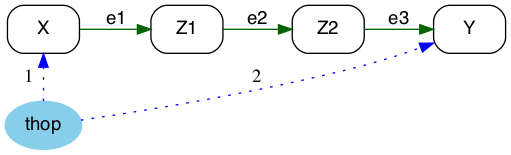

------------------------------------------------------------
------------------------------------------------------------

PW: 2

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Y","Z2"). e("Z2","Y"). thop("X","Y").


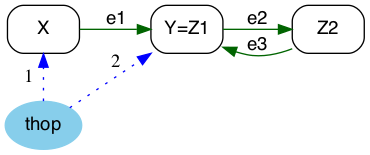

------------------------------------------------------------
------------------------------------------------------------

PW: 3

Partitioning Description:


Specialized Query:


Canonical DB:
e("Y","Y"). e("Z1","Y"). e("X","Z1"). thop("X","Y").


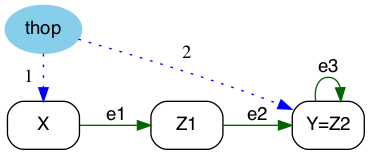

------------------------------------------------------------
------------------------------------------------------------

PW: 4

Partitioning Description:


Specialized Query:


Canonical DB:
e("Z1","Y"). e("X","Z1"). e("Z1","Z1"). thop("X","Y").


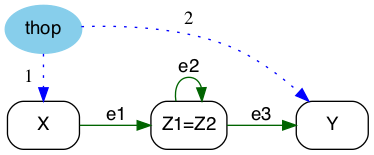

------------------------------------------------------------
------------------------------------------------------------

PW: 5

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Y","Y"). thop("X","Y").


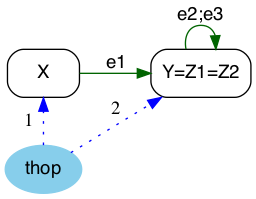

------------------------------------------------------------
------------------------------------------------------------

PW: 6

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Z1","X"). e("X","Z1"). thop("X","Y").


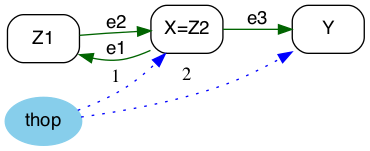

------------------------------------------------------------
------------------------------------------------------------

PW: 7

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Y","X"). thop("X","Y").


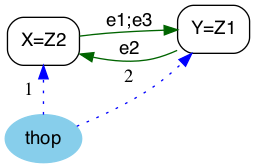

------------------------------------------------------------
------------------------------------------------------------

PW: 8

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("X","Z2"). e("Z2","Y"). thop("X","Y").


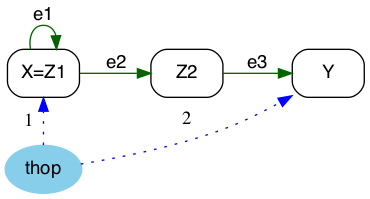

------------------------------------------------------------
------------------------------------------------------------

PW: 9

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("X","Y"). e("Y","Y"). thop("X","Y").


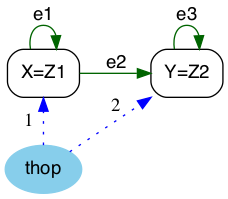

------------------------------------------------------------
------------------------------------------------------------

PW: 10

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("X","Y"). thop("X","Y").


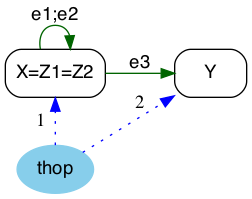

------------------------------------------------------------
------------------------------------------------------------

PW: 11

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Z1"). e("Z2","X"). e("Z1","Z2"). thop("X","X").


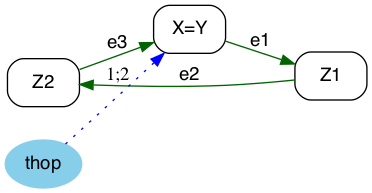

------------------------------------------------------------
------------------------------------------------------------

PW: 12

Partitioning Description:


Specialized Query:


Canonical DB:
e("Z1","X"). e("X","Z1"). e("Z1","Z1"). thop("X","X").


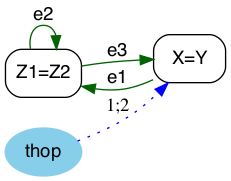

------------------------------------------------------------
------------------------------------------------------------

PW: 13

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("Z1","X"). e("X","Z1"). thop("X","X").


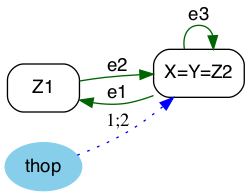

------------------------------------------------------------
------------------------------------------------------------

PW: 14

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("Z2","X"). e("X","Z2"). thop("X","X").


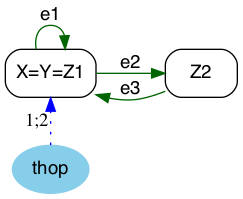

------------------------------------------------------------
------------------------------------------------------------

PW: 15

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). thop("X","X").


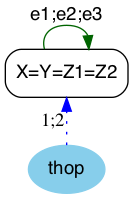

------------------------------------------------------------


In [11]:
for i in range(1, len(query_analysis['pw_objs'])+1):
    print('-'*60)
    print("\nPW:", i)
    pw_rel_dfs, pw_objs = pw_slicer(query_analysis['pw_rel_dfs'], query_analysis['pw_objs'], [i])
    pw_obj = pw_objs[0]
    
    print("\nPartitioning Description:")
    print_fancy_rewrite(pw_rel_dfs)
    
    print("Specialized Query:")
    print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=False)
    
    print("Canonical DB:")
    pw_edge_facts = get_edge_facts(pw_obj)
    pw_head_facts = get_query_head_facts(pw_obj)
    print(" ".join(pw_edge_facts+pw_head_facts))
    g = get_pattern_graph3(pw_rel_dfs, pw_obj, silent=True, q_head='hyperedge')
    # draw(g, filename='{}.{}'.format('3hop_all_patterns_new/pw_{}'.format(i), 'png'), show=False)
    display(draw(g))
    print('-'*60)

Above, we can see for each PW, the variable partitions (in blue), followed by the specialized query the PW represents, followed by a textual and visual representation of the canonical database of the specialized query.

These visual representations of the canonical databases are what we call ___graph-patterns___.

One outstanding issue is that these specialized queries/patterns aren't disjoint, _yet_, i.e. some of them are equivalent. To find the set of disjoint set of these specialized queries/patterns, we check for isomorphisms between these canonical databases. If there exists an isomorphism between two canonical databases (and hence the graph patterns), the two specialized queries (and the graph patterns) are equivalent, and can be grouped together.

Below is the encoding that checks if there exists such an isomorphism for two such canonical databases:

In [12]:
%%clingo --donot-display_input -lci qep_eq_check --donot-run

% e(X,Y) :- e(Y,X). --> only if undirected
gnode1(X) :- e1(X,_).
gnode1(X) :- e1(_,X).

gnode2(X) :- e2(X,_).
gnode2(X) :- e2(_,X).

vmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).
:- vmap(X1,Y1), vmap(X2,Y2), e1(X1,X2), not e2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not e1(X1,X2), e2(Y1,Y2).

% 3hop Query
:- vmap(X1,Y1), vmap(X2,Y2), thop1(X1,X2), not thop2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not thop1(X1,X2), thop2(Y1,Y2).

:- gnode1(X), #count {Y: vmap(X,Y)} != 1.
:- gnode2(Y), #count {X: vmap(X,Y)} != 1.

#show.

We can now use PWE to compute the disjoint groups efficiently using the above encoding:

In [13]:
sets = get_equivalent_sets(query_analysis['pw_objs'], lambda pw1, pw2: are_equivalent_patterns(pw1,pw2,qep_eq_check))

In [14]:
for s in sets:
    print({pw.pw_id for pw in s})

{1}
{2}
{3}
{4}
{5}
{6}
{7}
{8}
{9}
{10}
{11}
{12}
{13, 14}
{15}


In [15]:
len(sets)

14

As we can see, there are 14 disjoint specialized queries (as opposed to 15), since specialized queries 13 and 14 are equivalent. Let's take a look at their graph patterns again to see why that's the case:

------------------------------------------------------------

PW: 13
Canonical DB:
e("X","X"). e("Z1","X"). e("X","Z1"). thop("X","X").


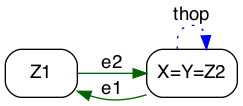

------------------------------------------------------------
------------------------------------------------------------

PW: 14
Canonical DB:
e("X","X"). e("Z2","X"). e("X","Z2"). thop("X","X").


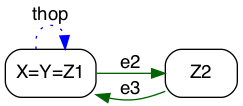

------------------------------------------------------------


In [16]:
for i in [13,14]:
    print('-'*60)
    print("\nPW:", i)
    pw_rel_dfs, pw_objs = pw_slicer(query_analysis['pw_rel_dfs'], query_analysis['pw_objs'], [i])
    pw_obj = pw_objs[0]
    
    print("Canonical DB:")
    pw_edge_facts = get_edge_facts(pw_obj)
    pw_head_facts = get_query_head_facts(pw_obj)
    print(" ".join(pw_edge_facts+pw_head_facts))
    g = get_pattern_graph3(pw_rel_dfs, pw_obj, silent=True, q_head='binary-edge')
    display(draw(g))
    print('-'*60)

As we can verify, the two are indeed equivalent. We can swap "Z1" with "Z2" in the first one or vice-versa in the second one, to get the other canonical database, meaning there exists an isomorphism between the two.

### Building a hierarchy of _semi_-specialized queries

In the specialized queries above, we explicitly encode the equalities and in/dis-equalities between the variables in the query. Say we only encode the equalities but not the in/dis-equalities. This gives us a set of _semi_-specialized queries which can be arranged in a hierarchy based on query containment relations. We build these queries and their hierarchy below.

Below is an ASP encoding to check for query containment between two queries Q1 and Q2 (is Q2 contained in Q1?) based on their canonical databases:

In [17]:
%%clingo --donot-display_input -lci qep_containment_check --donot-run

% Project out the nodes of the two queries
gnode1(X) :- e1(X,_).
gnode1(X) :- e1(_,X).

gnode2(X) :- e2(X,_).
gnode2(X) :- e2(_,X).

% Generate a mapping from variables of Q1 to variables of Q2:
vmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).

% Test that for every edge e1(X1,Y1) and thop(X1,Y1) in Q1 there is an edge e2(Y1,Y2) and thop(Y1,Y2) in Q2 s.t.
% X1 maps to Y1 and X2 maps to Y2
:- vmap(X1,Y1), vmap(X2,Y2), e1(X1,X2), not e2(Y1,Y2).

:- vmap(X1,Y1), vmap(X2,Y2), thop1(X1,X2), not thop2(Y1,Y2).

% Test vice-versa. In this case, we need to ensure that there is "at least" one such edge/thop.
e2_mapped(Y1,Y2) :- vmap(X1,Y1), vmap(X2,Y2), e1(X1,X2), e2(Y1,Y2).
:- gnode2(Y1), gnode2(Y2), e2(Y1,Y2), not e2_mapped(Y1,Y2).

thop2_mapped(Y1,Y2) :- vmap(X1,Y1), vmap(X2,Y2), thop1(X1,X2), thop2(Y1,Y2).
:- gnode2(Y1), gnode2(Y2), thop2(Y1,Y2), not thop2_mapped(Y1,Y2).

% Ensure that it is a many-to-one/one-to-one mapping
:- gnode1(X), #count {Y: vmap(X,Y)} != 1.

#show.

In [18]:
# Function to test whether query Q1 (represented by pw1) contains query Q2 (represented by pw2)
# using the above encoding
def q1_contains_q2(pw1, pw2):
    return are_equivalent_patterns(pw1, pw2, qep_containment_check)

In [19]:
# Save figures for each PW (to build the hierarchy)
query_fig_fnames = save_query_figs(query_analysis, folder='3hop_all_patterns_new')

Next, we create the hierarchy of the queries:

In [20]:
g = nx.MultiDiGraph()
for pw_id in range(1, len(query_analysis['pw_objs'])+1):
    fname = query_fig_fnames[pw_id]
    g.add_node(pw_id, image=os.path.abspath(fname),
               shape='box', fixedsize='true', imagescale='true', size=2, label=" ")

Let's add edges based on query containment between all the queries:

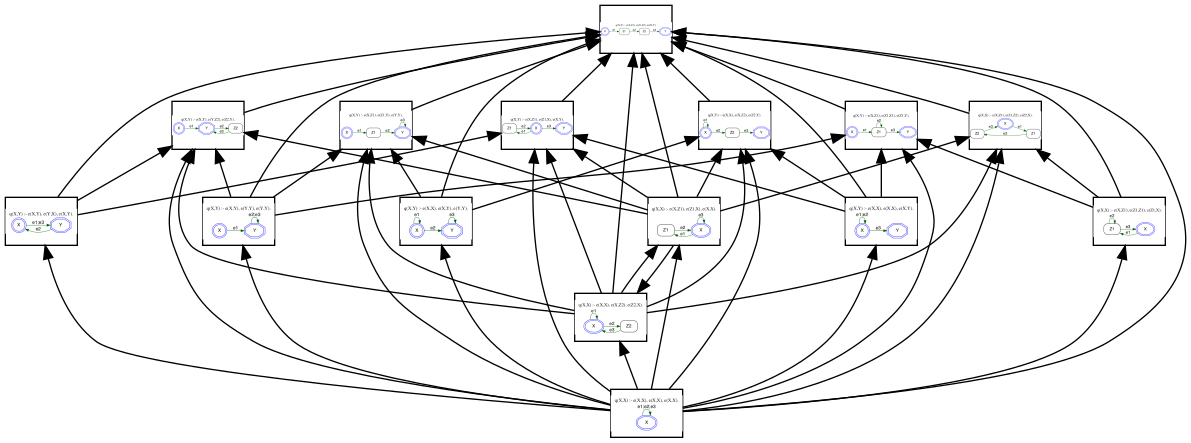

In [21]:
for pw_id1 in range(1, len(query_analysis['pw_objs'])+1):
    for pw_id2 in range(1, len(query_analysis['pw_objs'])+1):
        if pw_id1 == pw_id2:
            continue
        if q1_contains_q2(query_analysis['pw_objs'][pw_id1-1], query_analysis['pw_objs'][pw_id2-1]):
            g.add_edge(pw_id1, pw_id2, dir='back')

draw(g)

As we can see above, PW-13 and PW-14 have bi-directional containment, meaning they are equivalent. Recall that we already knew this from the isomorphism test earlier.

We can hence contract PW-13 and PW-14 into a single node:

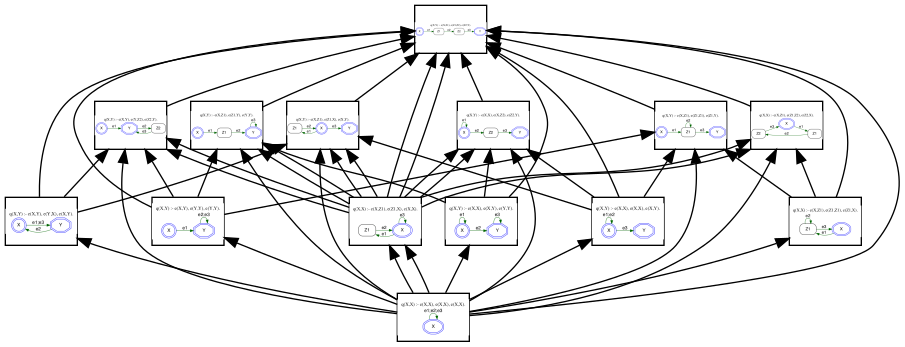

In [22]:
g = nx.contracted_nodes(g, 13, 14, self_loops=False)
draw(g)

To make the hierarchy easier to analyze, we remove the redundant transitive edges using a transitive reduction.

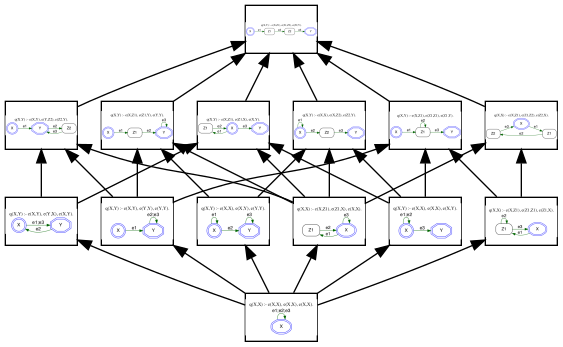

In [23]:
g_ = nx.algorithms.dag.transitive_reduction(g)

# Copy over the style properties (the nx.algorithms.dag.transitive_reduction loses these)
for n in g.nodes:
    for k,v in g.nodes[n].items():
        g_.nodes[n][k] = v
for e in g_.edges:
    g_.edges[e]['dir'] = 'back'
draw(g_)

The arrows can be iterpreted as ___'isa'___ relations.

In [24]:
# draw(g_, filename='3hop_query_hierarchy.gv', show=False)
# draw(g_, filename='3hop_query_hierarchy.pdf', show=False)